# Hausaufgaben Bayer

Your task is to check the feasability of an automated sentiment analysis tool for EPARs, ultimately helping the regulatory colleagues to quickly
identify (sub-) optimal clinical trial properties and learn from competitor
activities.

In [ ]:
!pip install pandas
!pip install xlrd
!pip install seaborn
!pip install spacy
!pip install nltk
!pip install PyPDF2

In [ ]:
!python -m spacy download en 

In [3]:
import pandas as pd

In [4]:
# Constants
color_bayer_dark_blue = '#333399'
color_bayer_light_blue = '#01BEFF'
color_bayer_green = '#56D500'

In [5]:
# load data
df = pd.read_excel('data/sentences_with_sentiment_final.xls')

In [6]:
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


## Missing Values

In [7]:
# check for missing values --> no missing values
df.isnull().sum()

ID          0
Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

## Feature Engineering

In [8]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [9]:
# add feature that describes sentiment as one number
df['Sentiment'] = df.apply(lambda x: 0 if x['Negative'] else 1 if x['Neutral'] else 2, axis=1)
df['Sentiment_Text'] = df.apply(lambda x: 'Negativ' if x['Negative'] else 'Neutral' if x['Neutral'] else 'Positiv', axis=1)

In [10]:
# check if sentence has two sentiments --> no
df[['Positive', 'Negative', 'Neutral']].iloc[0].sum()

1

In [11]:
df['Sentiment'].value_counts()

2    160
1     70
0     36
Name: Sentiment, dtype: int64

In [12]:
# construct df with two sentiments by merging neutral and negative (the ones with the fewest examples)
df['Sentiment_Easy'] = df['Sentiment'].apply(lambda x: 1 if x == 2 else 0)
df['Sentiment_Easy_Text'] = df['Sentiment_Easy'].apply(lambda x: 'Positiv' if x == 1 else 'Other')

In [13]:
df.head(5)

,ID,Sentence,Positive,Negative,Neutral,Sentiment,Sentiment_Text,Sentiment_Easy,Sentiment_Easy_Text
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,Positiv,1,Positiv
1,2,The long duration of response and high durable...,1,0,0,2,Positiv,1,Positiv
2,3,The median OS time in the updated results exce...,0,0,1,1,Neutral,0,Other
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,Positiv,1,Positiv
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,Positiv,1,Positiv


In [14]:
# check if there are only two categories after merging neutral and negative
df['Sentiment_Easy'].value_counts()

1    160
0    106
Name: Sentiment_Easy, dtype: int64

In [15]:
# remove punctiation, stop words and lemmatisation
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

def clean_sentence(sentence):
    # convert sentence into tokens (words)
    sentence = nlp(sentence)
    # Lemmatizing  
    sentence = [word.lemma_.lower().strip() for word in sentence]
   
    # remove stop words
    return [word for word in sentence if word not in stop_words and word not in string.punctuation]
    

df['Sentence_Cleaned'] = df['Sentence'].apply(lambda x: " ".join(clean_sentence(x)))

In [16]:
df.head(1)

,ID,Sentence,Positive,Negative,Neutral,Sentiment,Sentiment_Text,Sentiment_Easy,Sentiment_Easy_Text,Sentence_Cleaned
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,Positiv,1,Positiv,result 2nd line treatment orr 33 patient durab...


## Data Exploration

In [54]:
import nltk
import re
import PyPDF2
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.collocations import BigramCollocationFinder
from nltk import word_tokenize
from os import listdir
from os.path import isfile, join

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,266.0,133.500000,76.931788,1.0,67.25,133.5,199.75,266.0
Positive,266.0,0.601504,0.490511,0.0,0.00,1.0,1.00,1.0
Negative,266.0,0.135338,0.342729,0.0,0.00,0.0,0.00,1.0
Neutral,266.0,0.263158,0.441177,0.0,0.00,0.0,1.00,1.0
Sentiment,266.0,1.466165,0.722144,0.0,1.00,2.0,2.00,2.0
Sentiment_Easy,266.0,0.601504,0.490511,0.0,0.00,1.0,1.00,1.0


In [19]:
# How many examples do we have per vote
df[['Positive', 'Negative', 'Neutral']].value_counts()

Positive  Negative  Neutral
1         0         0          160
0         0         1           70
          1         0           36
dtype: int64

In [20]:
bayer_colors = [color_bayer_green, color_bayer_dark_blue, color_bayer_light_blue]
customPalette = sns.set_palette(sns.color_palette(bayer_colors))

[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Anzahl'),
 Text(0.5, 1.0, 'Anzahl Beispiele per Sentiment')]

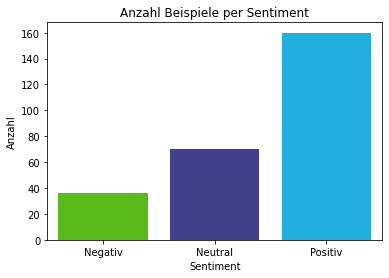

In [21]:
ax = sns.countplot(x='Sentiment_Text', data=df, palette=customPalette, order=['Negativ', 'Neutral', 'Positiv'] )
ax.set(xlabel="Sentiment", ylabel = "Anzahl", title="Anzahl Beispiele per Sentiment")

In [22]:
# check if there is more than one sentiment assigned to same sentence --> there is not
df.apply(lambda x: False if sum([x['Negative'], x['Neutral'], x['Positive']]) > 1 else True, axis=1).value_counts()

True    266
dtype: int64

### Finde relevante Sätze

In [25]:
# find most common words with frequency
sentences_list = df['Sentence_Cleaned']
sentences = " ".join(sentences_list)
doc = nlp(sentences)
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
word_freq = Counter(words)
most_common_words_count = word_freq.most_common(25)

for i in most_common_words_count:
    print(f'{i[0]}: {i[1]}')

study: 102
safety: 81
datum: 65
patient: 52
efficacy: 47
treatment: 40
clinical: 38
product: 38
consider: 35
profile: 31
support: 30
ct: 30
p10: 30
dose: 27
provide: 25
result: 23
subject: 23
compare: 22
mg: 22
week: 22
additional: 21
combination: 21
difference: 20
effect: 19
term: 19


In [26]:
# extract most common words
most_common_words = [' ' + x[0] for x in most_common_words_count]

In [33]:
# check how many common words a sentence has
def count_common_words(sentences_list, most_common_words, start = 0, up_to = 5):
    sentences_with_multiple_common_words = []
    sentences_word_coverage = {}
    for num in range(start,up_to):
        for sent in sentences_list:
            word_matches = [c_w for c_w in most_common_words if c_w in sent]
            if  len(word_matches) > num:
                sentences_with_multiple_common_words.append(sent)

        print(f'{len(sentences_with_multiple_common_words)* 100 / len(sentences_list):.2f}% der Sätze beinhalten {str(num+1)} der Top 25 Wörter')
        sentences_word_coverage[num+1] = len(sentences_with_multiple_common_words)* 100 / len(sentences_list)
        sentences_with_multiple_common_words.clear()
    return sentences_word_coverage

In [34]:
sentences_word_coverage = count_common_words(sentences_list, most_common_words)

91.35% der Sätze beinhalten 1 der Top 25 Wörter
72.93% der Sätze beinhalten 2 der Top 25 Wörter
49.25% der Sätze beinhalten 3 der Top 25 Wörter
30.83% der Sätze beinhalten 4 der Top 25 Wörter
19.92% der Sätze beinhalten 5 der Top 25 Wörter


No handles with labels found to put in legend.


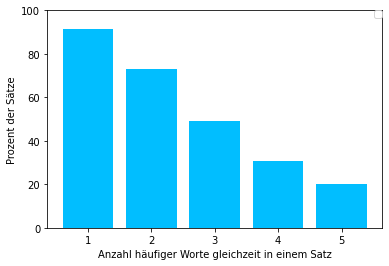

In [37]:
series = pd.Series(sentences_word_coverage) 
keys = sentences_word_coverage.keys()
vals = sentences_word_coverage.values()

plt.bar(keys, vals, color=color_bayer_light_blue)

plt.ylabel ('Prozent der Sätze')
plt.xlabel ('Anzahl häufiger Worte gleichzeit in einem Satz')
plt.xticks(list(keys))
plt.ylim(0,100)
#plt.title('Wieviel häufige Worte kommen gleichzeitig in relevanten Sätzen vor')
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

In [46]:
# ngram frequencies to detect relevant sentences --> might be good indicator but more reseach into 
# relevant groups required (e.g. group "of the" is just ctoo common everywhere)
sentences_list = df['Sentence'].tolist()
sentences = " ".join(sentences_list)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(sentences))
for k,v in sorted(finder.ngram_fd.items(), key=lambda item: item[1], reverse=True):
    print(k,v)
    if v == 10:
        break

('of', 'the') 68
('.', 'The') 67
('in', 'the') 51
(',', 'the') 37
('safety', 'profile') 24
('to', 'the') 23
('has', 'been') 22
('with', 'the') 21
('profile', 'of') 21
('patients', 'with') 20
('on', 'the') 19
('for', 'the') 19
('the', 'safety') 19
('in', 'patients') 16
('support', 'the') 15
('efficacy', 'of') 14
(')', '.') 14
('compared', 'to') 13
('from', 'the') 13
('safety', 'data') 13
('the', 'reference') 13
('to', 'be') 12
('.', 'In') 12
(',', 'and') 11
('have', 'been') 11
('clinical', 'data') 11
('the', 'FRC') 11
('by', 'the') 10


#### Extract important sentences from EPARs
1. Extract only Discussion section
2. Extract all sentences
3. check how many sentences contain common words from provided important sentences

In [47]:
def extract_relevant_sentences(filename, most_common_words, start, num_top_hits):
    pages = []
    with open(filename,'rb') as pdf_file:
        read_pdf = PyPDF2.PdfFileReader(pdf_file)
        number_of_pages = read_pdf.getNumPages()
        for page_number in range(number_of_pages):   # use xrange in Py2
            page = read_pdf.getPage(page_number)
            pages.append(page.extractText())
    
    text = " ".join(pages)
    text = text.lower()
    text = text.replace('\n', ' ')
    
    headline_indexes = [m.end(0) for m in re.finditer('2 scientific discussion| 2. scientific discussion', text)]
 
    # 1. Extract relevant section
    if len(headline_indexes) > 1:
        text = text[headline_indexes[1]:]
        
    # 2. extract sentences
    doc = nlp(text)
    
    # 3. Count sentences with common words
    count_common_words([x.text for x in doc.sents], most_common_words, start, num_top_hits)

In [53]:
# Print word frequency stats for EPARs
epar_files = [f for f in listdir('EPARs') if isfile(join('EPARs', f))]
for index, file in enumerate(epar_files):
    print(f'\n{index}.{file}')
    extract_relevant_sentences('EPARs/' + file, most_common_words,0, 5)


0.1. gilenya-epar-public-assessment-report_en.pdf
36.26% der Sätze beinhalten 1 der Top 25 Wörter
16.02% der Sätze beinhalten 2 der Top 25 Wörter
6.84% der Sätze beinhalten 3 der Top 25 Wörter
2.22% der Sätze beinhalten 4 der Top 25 Wörter
0.91% der Sätze beinhalten 5 der Top 25 Wörter

1.1. taltz-epar-public-assessment-report_en.pdf
37.62% der Sätze beinhalten 1 der Top 25 Wörter
14.77% der Sätze beinhalten 2 der Top 25 Wörter
5.82% der Sätze beinhalten 3 der Top 25 Wörter
2.17% der Sätze beinhalten 4 der Top 25 Wörter
0.67% der Sätze beinhalten 5 der Top 25 Wörter

2.1. temozolomide-teva-epar-public-assessment-report_en.pdf
44.72% der Sätze beinhalten 1 der Top 25 Wörter
21.34% der Sätze beinhalten 2 der Top 25 Wörter
8.13% der Sätze beinhalten 3 der Top 25 Wörter
2.03% der Sätze beinhalten 4 der Top 25 Wörter
0.41% der Sätze beinhalten 5 der Top 25 Wörter

3.1. vargatef-epar-public-assessment-report_en.pdf
33.18% der Sätze beinhalten 1 der Top 25 Wörter
13.80% der Sätze beinhalten 